In [36]:
# Loading and parsing data

# PLOT - parse data + std-dev
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
from matplotlib import ticker
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

data_path = os.path.join(os.path.pardir, 'data', 'tradeoffs')


def filter_data(data, bench, operation, filter_first_n=0):
    filtered_data = []
    ignore_count = 0
    for entry in data:
        if "msg" in entry and entry["msg"] == "Start benchmark":
            ignore_count += filter_first_n
        elif "bench" in entry and entry["bench"] == bench and "operation" in entry and entry["operation"] == operation:
            if ignore_count == 0:
                filtered_data.append(entry)
            else:
                ignore_count -= 1
    return filtered_data


def get_msg(entry):
    if "message" in entry:
        return entry["message"]

    if "msg" in entry:
        return entry["msg"]

    return ""



def read_data(path):
    global warmup
    data = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("{"):
                entry = json.loads(line)
                msg = get_msg(entry)
                if msg == "Benchmark result" or msg == "Start benchmark":
                    data.append(entry)
                elif msg == "Config":
                    warmup = entry["warmup"]
    return data

data = read_data(os.path.join(data_path, 'gyorgy_step_results.txt'))
filtered_data = filter_data(data, "BenchSteppedCreate", "session_creation")

#print(filtered_data)

/tmp/ipykernel_4095642/3448534508.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [37]:
def p50_estimator(x):
    return np.percentile(x, 50)
def p95_estimator(x):
    return np.percentile(x, 95)
def p99_estimator(x):
    return np.percentile(x, 99)

In [38]:
bg_num_field = "start_size"
version_field = "version"
value_field = "value"
import statistics

def get_unique_fields(data, fields):
    result = dict()
    for field in fields:
        result[field] = set()

    for entry in data:
        for field in fields:
            if field in entry:
                result[field].add(entry[field])
    return result

dfs = []
def get_versions_and_vals(data, x_field, quantile):
    fields = get_unique_fields(data, [x_field, version_field])
    sorted_versions = sorted(fields[version_field])
    sorted_x = sorted(fields[x_field])

    versions_and_vals = dict()
    for version in sorted_versions:
        vv = dict()
        versions_and_vals[version] = vv
        vv["vals"] = all_vals = dict()
        vv["y_vals"] = y_vals = []
        vv["errors"] = errors = [[], []]
        vv["x_vals"] = plotted_x_vals = []

        for x_val in sorted_x:
            vals = []
            minimum = None
            maximum = None
            idx = -1
            for entry in data:
                if entry[version_field] == version and entry[x_field] == x_val:
                    idx += 1
                    #print(idx, warmup)
                    if idx >= warmup:
                        val = entry[value_field]
                        vals.append(val)
                        #print(version, x_val, val, idx)
                        #print('ok')
                        dfs.append([version, x_val, val, idx])
                        if minimum is None or val < minimum:
                            minimum = val
                        if maximum is None or val > maximum:
                            maximum = val
            if len(vals) > 1:
                all_vals[x_val] = vals
                plotted_x_vals.append(x_val)
                y_val = statistics.median(vals)
                y_vals.append(y_val)
                errors[0].append(y_val - np.quantile(vals, 1 - quantile))
                errors[1].append(np.quantile(vals, quantile) - y_val)

    return versions_and_vals
versions_and_vals = get_versions_and_vals(filtered_data, bg_num_field, 0.99)
print(dfs)
df = pd.DataFrame(data=dfs, columns=['type', 'pods', 'time', 'idx'])
#print(versions_and_vals)

[['kubernetes', 0, 1296, 1], ['kubernetes', 0, 1201, 2], ['kubernetes', 0, 1162, 3], ['kubernetes', 0, 1192, 4], ['kubernetes', 0, 1311, 5], ['kubernetes', 10, 1160, 1], ['kubernetes', 10, 1181, 2], ['kubernetes', 10, 1209, 3], ['kubernetes', 10, 1150, 4], ['kubernetes', 10, 1251, 5], ['kubernetes', 20, 1317, 1], ['kubernetes', 20, 1171, 2], ['kubernetes', 20, 1150, 3], ['kubernetes', 20, 1185, 4], ['kubernetes', 20, 1202, 5], ['kubernetes', 30, 1183, 1], ['kubernetes', 30, 1136, 2], ['kubernetes', 30, 1343, 3], ['kubernetes', 30, 1155, 4], ['kubernetes', 30, 1240, 5], ['kubernetes', 40, 1201, 1], ['kubernetes', 40, 1184, 2], ['kubernetes', 40, 1219, 3], ['kubernetes', 40, 1283, 4], ['kubernetes', 40, 1449, 5], ['kubernetes', 50, 1168, 1], ['kubernetes', 50, 1169, 2], ['kubernetes', 50, 1245, 3], ['kubernetes', 50, 1361, 4], ['kubernetes', 50, 1177, 5], ['kubernetes', 60, 1497, 1], ['kubernetes', 60, 1177, 2], ['kubernetes', 60, 1588, 3], ['kubernetes', 60, 1155, 4], ['kubernetes', 60,

In [39]:
print(df.groupby(['type', 'pods']).count())

                 time  idx
type       pods           
kubernetes 0        5    5
           10       5    5
           20       5    5
           30       5    5
           40       5    5
           50       5    5
           60       5    5
           70       5    5
           80       5    5
           90       5    5
           100      5    5
           110      5    5
           120      5    5
praas-k8s  0        5    5
           10       5    5
           20       5    5
           30       5    5
           40       5    5
           50       5    5
           60       5    5
           70       5    5
           80       5    5
           90       5    5
           100      5    5
           110      5    5
           120      5    5
praas-kn   0        5    5
           10       5    5
           20       5    5
           30       5    5
           40       5    5
           50       5    5
           60       5    5
           70       5    5
           80       5    5
 

/tmp/ipykernel_4095642/3393515004.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_4095642/3393515004.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(


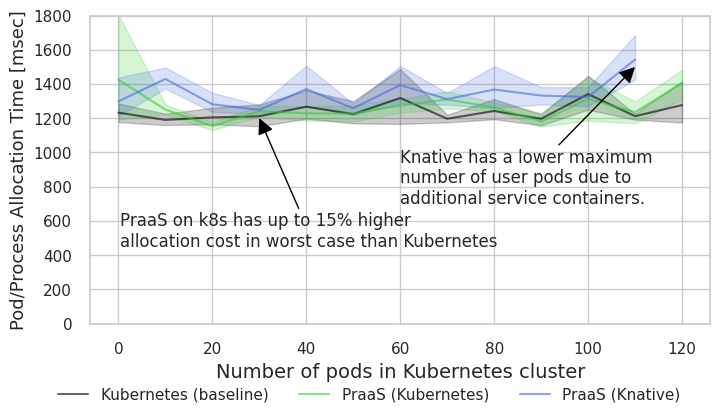

In [6]:

plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")
ax = plt.gca()


color = ['black','limegreen','royalblue','navy']


sns.lineplot(
    data=df,
    x="pods", y="time", hue="type", hue_order=["kubernetes", "praas-k8s", "praas-kn"],
    errorbar="ci", alpha=.6,#, height=6,
    #estimator=p50_estimator,
    palette=color,
    ax=ax
)

ax.set_xlabel('Number of pods in Kubernetes cluster',fontsize=14)
ax.set_ylabel('Pod/Process Allocation Time [msec]',fontsize=13)
ax.set_ylim([0, 1800])


ax.legend(loc='center', bbox_to_anchor=(0.45, -0.23),
    handles=ax.get_legend_handles_labels()[0],
    labels=['Kubernetes (baseline)', 'PraaS (Kubernetes)', 'PraaS (Knative)'],
    ncols=4        
)

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",color='black',shrinkA=0,shrinkB=0)

plt.annotate("PraaS on k8s has up to 15% higher\nallocation cost in worst case than Kubernetes",
             ha='left',xy=(30,1200), xytext=(0.3,450), arrowprops=prop)

plt.annotate("Knative has a lower maximum\nnumber of user pods due to\nadditional service containers.",
             ha='left',xy=(110,1500), xytext=(60,700), arrowprops=prop)

#plt.annotate("Difference between PraaS (k8s) and k8sAllocation of processesLower maximum number", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)

#plt.annotate("Difference between PraaS (k8s) and k8sAllocation of processesLower maximum number", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)


#plt.annotate("", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)

ax.figure.savefig("tradeoff_allocation.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)


In [34]:

print('k8s', 'praask8s', 'delta', 'ratio', 'coefficient of variance (praask8s)', 'coefficient of variance (k8s)')
for pods in range(0,130,10):
    k8s = df.loc[(df['type'] == 'kubernetes') & (df['pods'] == pods)]['time'].mean()
    k8s_dev = df.loc[(df['type'] == 'kubernetes') & (df['pods'] == pods)]['time'].std()
    praask8s = df.loc[(df['type'] == 'praas-k8s') & (df['pods'] == pods)]['time'].mean()
    praask8s_dev = df.loc[(df['type'] == 'praas-k8s') & (df['pods'] == pods)]['time'].std()
    knative = df.loc[(df['type'] == 'knative') & (df['pods'] == pods)]['time'].mean()
    print(k8s,praask8s,praask8s-k8s,praask8s/k8s, praask8s_dev/praask8s*100, k8s_dev/k8s*100)

print(df.groupby(['type', 'pods']).mean())

k8s praask8s delta ratio coefficient of variance (praask8s) coefficient of variance (k8s)
1158.6 1572.0 413.4000000000001 1.3568099430346972 27.77404247493309 83.95228887111348
175.6 1745.6 1570.0 9.940774487471526 2.420532227165761 22.6705846205869
1546.0 1854.0 308.0 1.1992238033635187 2.2216068313504826 47.17838402631505
1862.4 1751.4 -111.0 0.9403994845360825 2.830661411970032 1.884886748875635
1877.2 1767.2 -110.0 0.9414020882164926 2.8455285765237446 0.531908626310105
1882.0 1768.0 -114.0 0.9394261424017003 2.8940268790647132 1.1701761713892262
1886.0 1712.2 -173.79999999999995 0.907847295864263 3.794802618030572 1.6113013148486472
1891.8 1687.2 -204.5999999999999 0.891849032667301 3.766641009238975 1.7052480286950271
971.0 1733.6 762.5999999999999 1.7853759011328527 1.2522753200937924 89.76111853776898
1521.4 1815.6 294.1999999999998 1.1933745234652293 2.086657489006332 53.40581244978894
1889.8 1649.4 -240.39999999999986 0.8727907715102128 9.983186947491674 2.57916991445648
1870

# Deallocating the pod

In [41]:
data = read_data(os.path.join(data_path, 'gyorgy_step_results.txt'))
filtered_data = filter_data(data, "BenchSteppedCreate", "session_garbage_collect")

data = []
for d in filtered_data:
    data.append([d['version'], d['start_size'], d['value']])
df = pd.DataFrame(data=data, columns=['type', 'pods', 'time'])

df['is_first'] = ~df.duplicated(subset=['type', 'pods'], keep='first')
df = df[~df['is_first']].drop(columns=['is_first'])

#print(df.groupby(['type', 'pods'])['time'].count())
print(df.groupby(['type', 'pods'])['time'].median())


type        pods
kubernetes  0        1709.0
            10        179.0
            20       1850.0
            30       1869.0
            40       1872.0
            50       1889.0
            60       1880.0
            70       1892.0
            80        857.0
            90       1879.0
            100      1885.0
            110      1868.0
            120      1918.0
praas-k8s   0        1726.0
            10       1764.0
            20       1852.0
            30       1761.0
            40       1756.0
            50       1761.0
            60       1697.0
            70       1678.0
            80       1736.0
            90       1829.0
            100      1632.0
            110      1710.0
            120      1615.0
praas-kn    0       61169.0
            10      60562.0
            20      61252.0
            30      61583.0
            40      61561.0
            50      60819.0
            60      60601.0
            70      60983.0
            80      61694.0
   

In [10]:
data_path = os.path.join(os.path.pardir, 'data', 'tradeoffs')
# read praas data
#for size in sizes:
data = pd.read_csv(os.path.join(data_path, 'deallocation_gyorgy.txt'), sep=' ')
print(data)
print(data.groupby(['type', 'pods'])['time'].median())

           type  pods   time  repetition
0    kubernetes     0   1841           2
1    kubernetes     0    146           3
2    kubernetes     0   2040           4
3    kubernetes     0     57           5
4    kubernetes    10    179           2
..          ...   ...    ...         ...
147    praas-kn   100  61126           5
148    praas-kn   110  61028           2
149    praas-kn   110  60967           3
150    praas-kn   110  61975           4
151    praas-kn   110  61920           5

[152 rows x 4 columns]
type        pods
kubernetes  0         993.5
            10        170.0
            20       1850.0
            30       1865.5
            40       1871.0
            50       1892.0
            60       1878.0
            70       1886.0
            80        506.5
            90       1877.5
            100      1870.0
            110      1874.5
            120      1881.5
praas-k8s   0        1707.0
            10       1739.5
            20       1839.5
            30     